<a href="https://colab.research.google.com/github/alhichri/Heartprint/blob/main/Heartprint_biometrics_dataset_classification_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from concurrent.futures import ProcessPoolExecutor

import cv2
import scipy.io
import joblib
import numpy as np
import pywt
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import resize

import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
#import keras (high level API) wiht tensorflow as backend
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model , Sequential

from tensorflow.keras.layers import GlobalAveragePooling1D, LayerNormalization, Permute, Layer, Input, Add, Dense, \
    Flatten, Activation, Lambda, Conv2D, BatchNormalization, Conv3D, Layer, MaxPooling2D
from tensorflow.keras import layers, activations
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, VGG16, VGG19
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, efficientnet

TensorFlow version: 2.8.2


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive' , force_remount=True)

Mounted at /content/gdrive


In [ ]:
from importlib.machinery import SourceFileLoader
from importlib.util import spec_from_loader, module_from_spec

library_path = '/content/gdrive/MyDrive/000research/13-INF2168-02-R/colab_code/ECG-Classification-Using-CNN-and-CWT/EfficientBigEarthNet-main/'

somemodule = SourceFileLoader('gradcam', library_path+'gradcam.py').load_module()
from gradcam import GradCAM

somemodule = SourceFileLoader('inputs', library_path+'inputs.py').load_module()
from inputs import create_batched_dataset

somemodule = SourceFileLoader('modules', library_path+'modules.py').load_module()
from modules import se_module, cbam_module, coord_module, eca_module, ghost_module

somemodule = SourceFileLoader('metrics', library_path+'metrics.py').load_module()
from metrics import CustomMetrics

somemodule = SourceFileLoader('models', library_path+'models.py').load_module()
from models import MODELS_CLASS
import models


In [ ]:
dataset_path = '/content/gdrive/MyDrive/000research/13-INF2168-02-R/Data-ECG/PP-HB-199/'

mat = scipy.io.loadmat(dataset_path+'hb_p9_s1.mat')
# X = mat['X']; y = mat['y']; NUM_CLASSES = int(y.max()+1); print(NUM_CLASSES)
print(mat.keys())
h = mat['hbs']
print(h.shape)
number_of_subjects = h.shape[1]

# we have a problem with subject 145  h[0,145]  has shape 0,0
X = h[0 , 0] ; Y = np.zeros( ( X.shape[0])  ); 
label= 1
for s in range(1,number_of_subjects):
  h0 = h[0 , s]; label = h[1 , s][0][0]
  # print( 'heartbeats: ' , h0.shape , ' label: ', s)
  # if h0.shape[0]>0:
  X = np.vstack((X , h0))
  labels = label * np.ones( ( h0.shape[0]));     
  Y = np.hstack((Y ,  labels   ))
  # label = label + 1
NUM_CLASSES = int(label); print(NUM_CLASSES) 
Y = Y.astype('int')
print( X.shape , Y.shape)
# X_train: (7352, 128, 9) and X_test: (2947, 128, 9) 

Class_numbers_unique = np.unique(Y)
NUM_CLASSES =np.max( Y )+1
print( ' NUM_CLASSES: ' , NUM_CLASSES  )
print( ' number of unique classes: ' , Class_numbers_unique.shape)
# find the number of classes in one fold
class_size = np.zeros((NUM_CLASSES))
for i in Class_numbers_unique:
    class_size[i] = np.sum(Y == i)
print('Train class sizes: ' , class_size, 'Total: ' , np.sum( class_size))

########## remove non-exisitent labels
########## relabel data with new sequential labels
labels_dictionary = {}; new_Y= np.zeros(Y.shape).astype('int');  new_label = 0
for i in range(len(Y)):
  label = Y[i]
  if not( str(label) in labels_dictionary.keys()) :
    labels_dictionary[str(label)] = new_label
    new_label = new_label +1
  new_Y[i] = labels_dictionary[str(label)]

Class_numbers_unique = np.unique(new_Y)
NUM_CLASSES = np.max( new_Y )+1
print( ' NUM_CLASSES: ' , NUM_CLASSES  )
print( ' number of unique classes: ' , Class_numbers_unique.shape)
# find the number of classes in one fold
class_size = np.zeros((NUM_CLASSES))
for i in range(NUM_CLASSES):
    class_size[i] = np.sum(new_Y == i)
print('Train class sizes: ' , class_size, 'Total: ' , np.sum( class_size))

Y = new_Y

dict_keys(['__header__', '__version__', '__globals__', 'hbs'])
(2, 199)
220
(8205, 227) (8205,)
 NUM_CLASSES:  221
 number of unique classes:  (199,)
Train class sizes:  [ 29.   0.  40.  32.  30.  33.  38.  35.  28.  34.  29.  33.  35.  33.
  33.  47.  40.  29.  40.  28.  41.  35.  23.  30.  30.  39.  30.  31.
  42.  33.  34.  29.  46.  26.  24.  30.  33.  33.  44.  32.  39.  33.
  25.  30.  42.  31.  31.  23.  20.  23.  35.  28.  31.  35.  22.  32.
  38.  42.  44.  39.  44.  47.  40.  39.  36.  34.  37.  32.  37.  45.
  42.  37.  32.  40.  31.  36.  33.  29.  35.  35.  25.  29.  26.  29.
  32.  30.  28.  30.  31.  44.  40.  38.  37.  30.  30.  35.  33.  30.
  25.  34.  43.  35.  31.  46.  34.  32.  35.  45.  35.  44.  38.  45.
  29.  40.  31.  32.  28.  28.  41.  37.  31.  25.  32.  36.  39.  32.
  37.  26.  32.  27.  35.  30.  35.  40.  30.  32.  37.  29.  32.  35.
  33.  32.  34.  44.  24.  28.  28.  36.  41.  28.  42.  38.  30.  31.
  28.  35.  31.  39.  29.  37.  30.  36.  42.  32

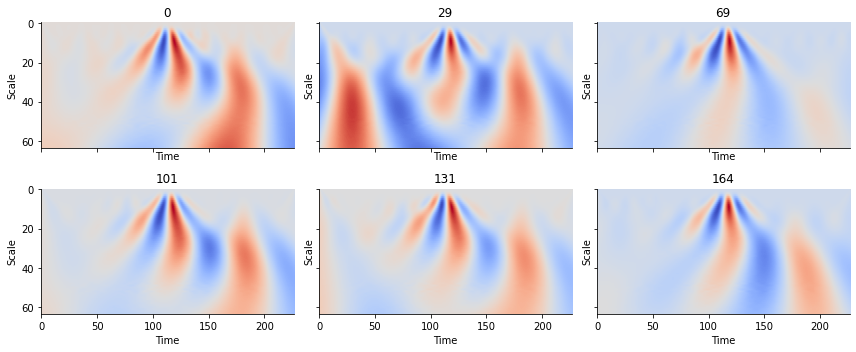

In [ ]:
# ###########################################
# # plot ECG beats and CWT images
# #######################################

def split_indices_per_label(y):
    number_of_classes = max( y ) - 1
    indicies_per_label = [[] for x in range(0,number_of_classes)]
    # loop over the six labels
    for i in range(number_of_classes): 
        indicies_per_label[i] = np.where(y == i)[0]
    return indicies_per_label

def plot_cwt_coeffs_per_label(X, label_indicies,  signal, sample, scales, wavelet):
    
    fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12,5))
    
    for ax, indices in zip(axs.flat, label_indicies):
        # apply  PyWavelets continuous wavelet transfromation function
        coeffs, freqs = pywt.cwt(X[indices[sample],:], scales, wavelet = wavelet)
        # create scalogram
        ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto')
        ax.set_title(str(indices[sample]))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_ylabel('Scale')
        ax.set_xlabel('Time')
        plt.tight_layout()

# list of list of sample indicies per activity
train_labels_indicies = split_indices_per_label(Y)

#signal indicies: 0 = body acc x, 1 = body acc y, 2 = body acc z, 3 = body gyro x, 4 = body gyro y, 5 = body gyro z, 6 = total acc x, 7 = total acc y, 8 = total acc z
signal = 3 # signal index
sample = 0 # sample index of each label indicies list
scales = np.arange(1, 65) # range of scales
wavelets = [ "mexh"  , "morl"  , "gaus5" ] # mother wavelet

plot_cwt_coeffs_per_label(X, train_labels_indicies,  signal, sample, scales, wavelet=wavelets[2])

dict_keys(['__header__', '__version__', '__globals__', 'hbs'])
(2, 199)


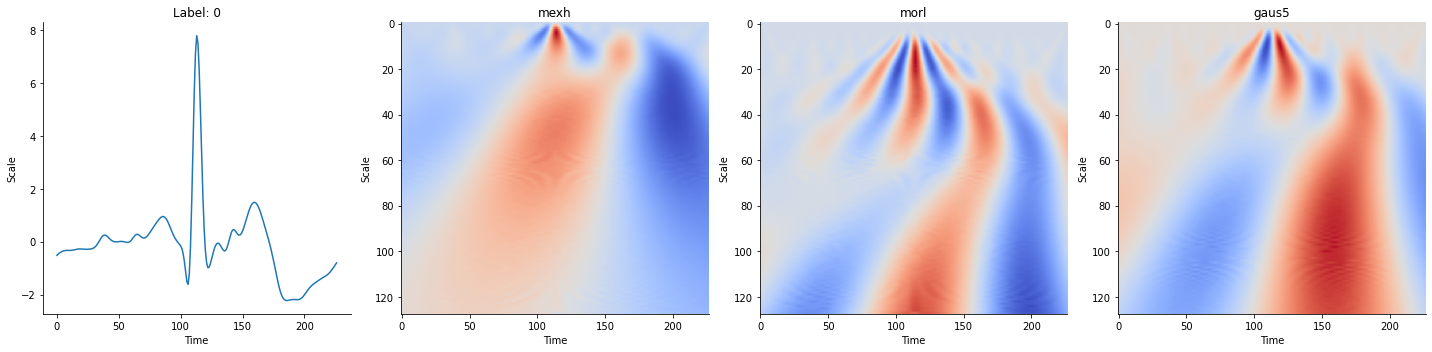

In [ ]:
###########################################
# Visulize one ECg heartbeat
#######################################
subject_number = 0 ; beat_number = 0 ;

mat = scipy.io.loadmat(dataset_path+'hb_p9_s1.mat')
# X = mat['X']; y = mat['y']; NUM_CLASSES = int(y.max()+1); print(NUM_CLASSES)
print(mat.keys())
h = mat['hbs']
print(h.shape)

heartbeats = h[0 , subject_number]; heartbeat  = heartbeats[beat_number]  #heartbeat_CWT = X[beat_number] ; heartbeat_label = Y[beat_number]
heartbeat_label =  h[1 , subject_number][0][0]-1

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
axs[0].plot( heartbeat )
axs[0].set_title('Label: ' + str(heartbeat_label))
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[0].set_ylabel('Scale')
axs[0].set_xlabel('Time')

# range of scales from 1 to n_scales
n_scales =  128; scales = np.arange(1, n_scales + 1) 
wavelets = [ "mexh"  , "morl"  , "gaus5" ]
for i in range(1,4):
  # continuous wavelet transform wavelet = "mexh"  # mexh, morl, gaus8, gaus4, 'sym5', 'coif5'
  coeffs1, freqs = pywt.cwt(heartbeat, scales, wavelet = wavelets[i-1]  ) 
  # create scalogram
  axs[i].imshow(coeffs1, cmap = 'coolwarm', aspect = 'auto')
  axs[i].set_title(  wavelets[i-1]  )
  axs[i].spines['right'].set_visible(False)
  axs[i].spines['top'].set_visible(False)
  axs[i].set_ylabel('Scale')
  axs[i].set_xlabel('Time')

plt.tight_layout()


In [ ]:
axs[0].plot(  heartbeat )

In [ ]:
# import pickle
# from sklearn.preprocessing import RobustScaler
# import numpy as np
# from sklearn.model_selection import train_test_split


# dataset_path = '/content/gdrive/MyDrive/000research/13-INF2168-02-R/Data-ECG/PP-HB-199/'

# mat = scipy.io.loadmat(dataset_path+'sig_R_s1.mat')
# # X = mat['X']; y = mat['y']; NUM_CLASSES = int(y.max()+1); print(NUM_CLASSES)
# print(mat.keys())
# h = mat['sig']
# print(h[0].shape , h[1].shape, h[2].shape)
# signals = h[0]; Rpeaks = h[1]; subject_index = h[2]
# number_of_subjects = subject_index.shape[0]
# print(signals[0][0].shape , Rpeaks[0][0].shape, subject_index[0].shape)
# S0= signals[0]; S1 = S0[0,0]; S2 = S1[0]
# signal_length = S2.shape[0]
# X = np.zeros( (signal_length)   ) ; R = -1*np.ones( (100)   )
# Y = np.array( [0]  ); 
# label= 0; 
# for i in range(number_of_subjects):
#   S0= signals[i]; R0 = Rpeaks[i]
#   number_of_records = S0.shape[1]
#   for j in range(number_of_records):
#     S1 = S0[0,j]; S2 = S1[0]
#     # print(S2.shape)
#     X = np.vstack((X , S2))
#     R1 = R0[0,j]; R2 = R1[0]
#     # print(R2.shape)
#     R3 = np.pad(R2, (0, 100 - len(R2)%100), 'constant')
#     R = np.vstack((R , R3))

#   labels = label * np.ones( (  number_of_records  ));     
#   Y = np.hstack((Y ,  labels.astype('int')   ))
#   label = label + 1

# NUM_CLASSES = int(label); print(NUM_CLASSES) 

# X = X[1:]; R = R[1:]; Y = Y[1:] 
# # data = {"signal": X, "r_peaks": R , "categories": Y}
# # print( data["signal"].shape , data["r_peaks"].shape  , data["categories"].shape)

# signals_and_peak = np.hstack( (X , R )  ); del X, R
# # split data
# X_trn, X_tst, Y_trn, Y_tst = train_test_split(signals_and_peak, Y, test_size=0.2, random_state=42)

# train_data = {"signal": X_trn[:,:-100] , "r_peaks": X_trn[:,-100:] , "categories": Y_trn}
# test_data = {"signal": X_tst[:,:-100] , "r_peaks": X_tst[:,-100:] , "categories": Y_tst}

# print( train_data["signal"].shape , train_data["r_peaks"].shape  , train_data["categories"].shape)
# print( test_data["signal"].shape , test_data["r_peaks"].shape  , test_data["categories"].shape)
# del X_trn, X_tst, Y_trn, Y_tst


In [ ]:
# ###########################################
# # Load data and extract CWT to convert to images
# #######################################
# def my_worker(X, r_peaks,category , wavelet, scales, sampling_period):
#   wavelet = "mexh"  # mexh, morl, gaus8, gaus4
#   coeffs1, frequencies = pywt.cwt(X, scales, "mexh", sampling_period)
#   coeffs2, frequencies = pywt.cwt(X, scales, "gaus8", sampling_period)
#   coeffs3, frequencies = pywt.cwt(X, scales, "morl", sampling_period)
#   # r_peaks, categories = data["r_peaks"], data["categories"]
#   # for remove inter-patient variation
#   avg_rri = np.mean(np.diff(r_peaks))
#   before, after = 90, 110;
#   x1, x2, y, groups = [], [], [], []
#   for i in range(len(r_peaks)):
#       # print( r_peaks[i] )
#       if i == 0 or i == len(r_peaks) - 1:
#           continue
#       if (r_peaks[i]==0):
#         break

#       # cv2.resize is used to sampling the scalogram to (100 x100)
#       img = np.zeros((3 , 64, 64))
#       img[0] = cv2.resize(coeffs1[:, r_peaks[i] - before: r_peaks[i] + after], (64, 64))
#       img[1] = cv2.resize(coeffs2[:, r_peaks[i] - before: r_peaks[i] + after], (64, 64))
#       img[2] = cv2.resize(coeffs3[:, r_peaks[i] - before: r_peaks[i] + after], (64, 64))
#       x1.append( img )
#       x2.append([
#           r_peaks[i] - r_peaks[i - 1] - avg_rri,  # previous RR Interval
#           r_peaks[i + 1] - r_peaks[i] - avg_rri,  # post RR Interval
#           (r_peaks[i] - r_peaks[i - 1]) / (r_peaks[i + 1] - r_peaks[i]),  # ratio RR Interval
#           np.mean(np.diff(r_peaks[np.maximum(i - 10, 0):i + 1])) - avg_rri  # local RR Interval
#       ])
#       y.append(category)
#       # groups.append(data["record"])

#   return x1, x2, y #, groups

# # def my_load_data(train_data , wavelet, scales, sampling_rate ):
# def my_load_data(train_data, wavelet, scales, sampling_rate  ):
#     # for training
#     x1_train, x2_train, y_train, groups_train = [], [], [], []
#     number_samples = len(train_data["signal"])
#     x1_train = np.zeros((1 , 3,64,64)); x2_train = np.zeros((1 , 4))
#     y_train = np.zeros((1))
#     for i in range(number_samples):
#       if (i%100==0): print(i , end='')
#       X = train_data["signal"][i]; r_peaks = train_data["r_peaks"][i].astype('int'); category = train_data["categories"][i]
#       x1, x2, y = my_worker(X, r_peaks,category , wavelet, scales, sampling_period)
#       x1 = np.array(x1); x2 = np.array(x2);  y = np.array(y); 
#       # print( x1.shape)
#       x1_train = np.vstack(( x1_train , x1 )); x2_train = np.vstack(( x2_train , x2 )); 
#       y_train = np.hstack(( y_train , y )); 
#     print('\n')
#       # print( x1[0].shape)
#     #   x1_train.append(x1)
#     #   x2_train.append(x2)
#     #   y_train.append(y)
#     #   # groups_train.append(groups)

#     # x1_train = np.expand_dims(np.concatenate(x1_train, axis=0), axis=1).astype(np.float32)
#     # # x1_train = np.concatenate(x1_train, axis=0).astype(np.float32)
#     # x2_train = np.concatenate(x2_train, axis=0).astype(np.float32)
#     # y_train = np.concatenate(y_train, axis=0).astype('int') #.astype(np.int64)
#     # # groups_train = np.concatenate(groups_train, axis=0)
#     # # normalization
#     x1_train = x1_train[1:]; x2_train = x2_train[1:]; y_train = y_train[1:];
#     return x1_train, x2_train, y_train
 

# sampling_rate = 360
# wavelet = "mexh"  # mexh, morl, gaus8, gaus4
# scales = pywt.central_frequency(wavelet) * sampling_rate / np.arange(1, 101, 1)
# sampling_period=1. / sampling_rate
# # (x1_train, x2_train, y_train), (x1_test, x2_test, y_test) = my_load_data(data,
# #     wavelet=wavelet, scales=scales, sampling_rate=sampling_rate  )
# x1_train, x2_train, y_train = my_load_data(train_data,  wavelet=wavelet, scales=scales, sampling_rate=sampling_rate  )
# x1_test, x2_test, y_test = my_load_data(test_data, wavelet=wavelet, scales=scales, sampling_rate=sampling_rate  )
# scaler = RobustScaler()
# x2_train = scaler.fit_transform(x2_train)
# x2_test = scaler.transform(x2_test)
# print( 'x1_train.shape: ' , x1_train.shape)
# print( 'x2_train.shape: ' , x2_train.shape)
# print( 'y_train.shape: ' , y_train.shape)

# print("Data loaded successfully!")


In [ ]:
# print( 'x1_train.shape: ' , x1_train.shape)
# print( 'x2_train.shape: ' , x2_train.shape)
# print( 'y_train.shape: ' , y_train.shape)
# # find the number of classes in one fold
# class_size = np.zeros((NUM_CLASSES))
# for i in range(NUM_CLASSES):
#     class_size[i] = np.sum(y_train == i)
# print('Train class sizes: ' , class_size, 'Total: ' , np.sum( class_size))
# # find the number of classes in one fold
# class_size = np.zeros((NUM_CLASSES))
# for i in range(NUM_CLASSES):
#     class_size[i] = np.sum(y_test == i)
# print('Test class sizes: ' , class_size,  'Total: ' , np.sum( class_size))

In [ ]:
########################################################
# No need to run this as results is already saved to hard disk
# load ECG heartbeat samples
# average each 10 consecutive beats
########################################################

dataset_path = '/content/gdrive/MyDrive/000research/13-INF2168-02-R/Data-ECG/PP-HB-199/'

def load_ECG_beats(fname):
    mat = scipy.io.loadmat(fname)
    # X = mat['X']; y = mat['y']; NUM_CLASSES = int(y.max()+1); print(NUM_CLASSES)
    print(mat.keys())
    h = mat['hbs']
    # print(h.shape)
    number_of_subjects = h.shape[1]
    # we have a problem with subject 145  h[0,145]  has shape 0,0
    X = h[0 , 0] ; Y = np.zeros( ( X.shape[0])  ); 
    labels_dictionary = {}; new_label = 0
    for s in range(number_of_subjects):
      h0 = h[0 , s]; label = h[1 , s][0][0]-1
      # print( 'heartbeats: ' , h0.shape , ' label: ', s)
      # if h0.shape[0]>0:
      number_of_heartbeats, number_of_samples = h0.shape
      for j in range(number_of_heartbeats-5):
        # average take 10 beats
        upper_index = np.min( [  j+10 , number_of_heartbeats  ])
        avg_beat = np.mean(  h0[j:upper_index, :] , axis=0 )
        X = np.vstack((X , avg_beat))
        Y = np.hstack((Y ,  label    ))
        # print( h0.shape , label )
        # label = label + 1
    NUM_CLASSES = int(label); print(NUM_CLASSES) 
    Y = Y.astype('int')
    print( X.shape , Y.shape)
    # X_train: (7352, 128, 9) and X_test: (2947, 128, 9) 
    return X, Y

data_path = '/content/gdrive/MyDrive/000research/13-INF2168-02-R/colab_code/ECG-Classification-Using-CNN-and-CWT/data_CWT/'

fname = dataset_path+'hb_p9_s1.mat'; X , Y = load_ECG_beats(fname)
np.savez( data_path+'session01.npz' ,  X=X, Y= Y      )

# fname = dataset_path+'hb_p9_s2.mat'; X , Y = load_ECG_beats(fname)
# np.savez( data_path+'session02.npz' ,  X=X, Y= Y      )

# fname = dataset_path+'hb_p9_s3R.mat'; X , Y = load_ECG_beats(fname)
# np.savez( data_path+'session03R.npz' ,  X=X, Y= Y      )

# fname = dataset_path+'hb_p9_s3L.mat'; X , Y = load_ECG_beats(fname)
# np.savez( data_path+'session03L.npz' ,  X=X, Y= Y      )

# X = np.vstack((X0 , X )); Y = np.hstack(( Y0 , Y ))
# print( X.shape , Y.shape)

dict_keys(['__header__', '__version__', '__globals__', 'hbs'])
219
(7239, 227) (7239,)


In [ ]:
Y

array([  0,   0,   0, ..., 151, 151, 151])

In [ ]:
########################################################
# No need to run this as results is already saved to hard disk
# load ECG heartbeat samples
# average each 10 consecutive beats
########################################################
# new method here https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442
discrete_wavelets = ['db5', 'sym5', 'coif5', 'bior2.4']
continuous_wavelets = ['mexh', 'morl', 'cgau5', 'gaus5']

def create_cwt_images(X, n_scales, rescale_size, wavelet_name = "morl"):
    n_samples = X.shape[0] 
    n_signals = 3 # X.shape[2] 
    print( 'n_samples: ', n_samples,  'n_signals: ' ,  n_signals  )
    # range of scales from 1 to n_scales
    scales = np.arange(1, n_scales + 1) 
    
    # pre allocate array
    X_cwt = np.ndarray(shape=(n_samples, rescale_size, rescale_size, n_signals ), dtype = 'float32')
    signal = 1
    for sample in range(n_samples):
        if sample % 1000 == 0:
            print(sample)
        # for signal in range(n_signals):
        serie = X[sample , :] # X[sample, :, signal]
        # continuous wavelet transform wavelet = "mexh"  # mexh, morl, gaus8, gaus4, 'sym5', 'coif5'
        coeffs1, freqs = pywt.cwt(serie, scales, wavelet = "mexh") 
        coeffs2, freqs = pywt.cwt(serie, scales, wavelet = "morl")
        coeffs3, freqs = pywt.cwt(serie, scales, wavelet = "gaus5")
        # resize the 2D cwt coeffs
        X_cwt[sample, :,: , 0] = resize(coeffs1, (rescale_size, rescale_size), mode = 'constant')
        X_cwt[sample, :,: , 1] = resize(coeffs2, (rescale_size, rescale_size), mode = 'constant')
        X_cwt[sample, :,: , 2] = resize(coeffs3, (rescale_size, rescale_size), mode = 'constant')
    # X_cwt  = np.squeeze(X_cwt)
    return X_cwt
  
# amount of pixels in X and Y 
rescale_size = 64
# determine the max scale size
n_scales = 64

session_name = 'session01'
# session_name = 'session02'
# session_name = 'session03L'
# session_name = 'session03R'

# /content/gdrive/MyDrive/000research/13-INF2168-02-R/colab_code/ECG-Classification-Using-CNN-and-CWT/data_CWT/session03L.npz
data_path = '/content/gdrive/MyDrive/000research/13-INF2168-02-R/colab_code/ECG-Classification-Using-CNN-and-CWT/data_CWT/'
fname = data_path+session_name+'.npz'; 
D = np.load( fname  )
X = D['X'];   Y = D['Y']
print( X.shape , Y.shape)

X_cwt = create_cwt_images(X, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: {X_cwt.shape}")

np.savez( data_path+session_name+ '_CWT.npz' , X = X_cwt , Y = Y  )


In [ ]:
########################################################
# load CWT features/images of heartbeats from any session
# uncomment the session you want
# 
########################################################

session_name = 'session01'
# session_name = 'session02'
# session_name = 'session03L'
# session_name = 'session03R'
data_path = '/content/gdrive/MyDrive/000research/13-INF2168-02-R/colab_code/ECG-Classification-Using-CNN-and-CWT/data_CWT/'
fname = data_path+session_name+ '_CWT.npz'
D = np.load( fname  )
X = D['X'];   Y = D['Y']
print( X.shape , Y.shape)



(7239, 64, 64, 3) (7239,)


In [ ]:
###########################################
# Prepare data for visualization 
#######################################
import torch
import cv2

def make_sym_log(X):
  rows, cols, depth = X.shape;  Z = np.zeros( X.shape )
  for r in range(rows):
    for c in range(cols):
      for d in range(depth):
        Z[r,c, d] = np.log( X[r,c, d]  +1 ) if X[r,c, d]>=0 else np.log( -X[r,c, d]  +1 )
  return Z

def convert_to_RGB(X):
  fig = plt.figure(frameon=False)
  ax = plt.Axes(fig, [0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)
  ax.imshow(X[:,:,0], aspect='equal')
  fig.savefig('band0.png', dpi=128, bbox_inches='tight',  pad_inches=0)

  fig = plt.figure(frameon=False)
  ax = plt.Axes(fig, [0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)
  ax.imshow(X[:,:,1], aspect='equal')
  fig.savefig('band1.png', dpi=128, bbox_inches='tight',  pad_inches=0)

  fig = plt.figure(frameon=False)
  ax = plt.Axes(fig, [0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)
  ax.imshow(X[:,:,2], aspect='equal')
  fig.savefig('band2.png', dpi=128, bbox_inches='tight',  pad_inches=0)

  band0 = cv2.imread('band0.png', cv2.IMREAD_UNCHANGED)
  # print('Original Dimensions : ',band0.shape)
  # width = 64; height = 64
  # dim = (width, height)
  # # resize image
  # resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  # print('Resized Dimensions : ',resized.shape)
  band1 = cv2.imread('band1.png', cv2.IMREAD_UNCHANGED)
  band2 = cv2.imread('band2.png', cv2.IMREAD_UNCHANGED)
  newRGBImage = cv2.merge((band0[:,:,0],band1[:,:,0],band2[:,:,0]))
  return newRGBImage


# Visualize some examples
batch = 10; plots_path = '/content/gdrive/MyDrive/000research/13-INF2168-02-R/colab_code/ECG-Classification-Using-CNN-and-CWT/plots/'
NUM_IMAGES = 12; sample_images = []; sample_labels= []; Z = np.zeros( X.shape )
for idx in range(NUM_IMAGES):
  rnd_index = np.random.randint(len(Y))
  # SYMMETRIC LOG Y=Logarithm(X+1) if X>0 Y=-logarithm(-X+1) if X<0
  Z = convert_to_RGB(   X[rnd_index]    );
  file_name = 'Label%03d'%Y[ rnd_index ]  + '_B%02d'%batch + '.png'
  cv2.imwrite( plots_path+file_name , Z    )
  sample_images.append( torch.tensor(    Z   )  )
  sample_labels.append(  str( Y[ rnd_index ] ) )
  
sample_images = torch.stack(  sample_images , dim=0)
# sample_images = np.array( sample_images  )




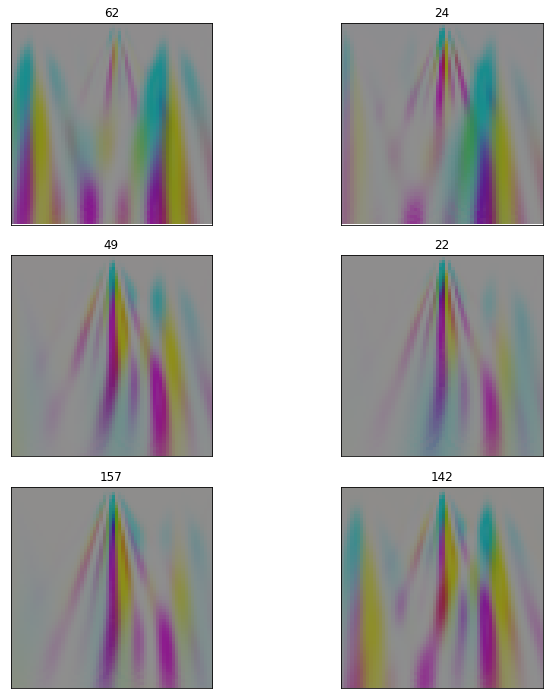

In [ ]:
###########################################
# Now visulize the CWT images
#######################################
fig = plt.figure(figsize=(10,10))
for i in range(6):
  plt.subplot(3,2,i+1); 
  plt.tight_layout()
  img = sample_images[i]; 
  # img = torch.squeeze(img[:,:,0])
  plt.imshow(img,  interpolation='none' )
  plt.title(   sample_labels[i]     )
  plt.xticks([])
  plt.yticks([])
# fig

In [ ]:
###########################################
# Load session 1 and 2 data and merge them
# I noticed here that labels are incomplete
# I had to reassign new consecutive and common labels 
#######################################
data_path = '/content/gdrive/MyDrive/000research/13-INF2168-02-R/colab_code/ECG-Classification-Using-CNN-and-CWT/data_CWT/'
D = np.load( data_path+'session01'+ '_CWT.npz'  ); X = D['X'];   Y = D['Y']
print( X.shape , Y.shape)

labels_dictionary = {}; new_label = 0
for i in range(len(Y)):
  label = Y[i]
  if not( str(label) in labels_dictionary.keys()) :
    labels_dictionary[str(label)] = new_label
    new_label = new_label +1
  Y[i] = labels_dictionary[str(label)]

Class_numbers_unique = np.unique(Y)
NUM_CLASSES =np.max( Y )+1
print( ' NUM_CLASSES: ' , NUM_CLASSES  )
print( ' number of unique classes: ' , Class_numbers_unique.shape)
# find the number of classes in one fold
class_size = np.zeros((NUM_CLASSES))
for i in range(NUM_CLASSES):
    class_size[i] = np.sum(Y == i)
print('Train class sizes: ' , class_size, 'Total: ' , np.sum( class_size))

############### now load session2 data
D = np.load( data_path+'session02'+ '_CWT.npz'  ); print( D['X'].shape , D['Y'].shape)
X2 = D['X'];   Y2 = D['Y']

# change labels for session 2
Class_numbers_unique = np.unique(Y); new_Y = np.zeros(Y2.shape)
print( ' number of unique classes: ' , Class_numbers_unique.shape)
for i in range(len(Y2)):
  old_label = str(Y2[i])
  new_label = labels_dictionary[ old_label  ]
  # print( old_label  , new_label   )
  new_Y[i] = int(  new_label  )
Y2 = new_Y

# Merge two sets
X = np.vstack(( X ,  X2) );   Y = np.hstack(( Y ,  Y2 )) ;
print( X.shape , Y.shape)

Class_numbers_unique = np.unique(Y)
NUM_CLASSES = int(np.max( Y )) + 1
print( ' NUM_CLASSES: ' , NUM_CLASSES  )
print( ' number of unique classes: ' , Class_numbers_unique.shape)
# find the number of classes in one fold
class_size = np.zeros((NUM_CLASSES))
for i in range(NUM_CLASSES):
    class_size[i] = np.sum(Y == i)
print('Train class sizes: ' , class_size, 'Total: ' , np.sum( class_size))

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print( 'Data splits: ' , X_train.shape , Y_train.shape , X_test.shape , Y_test.shape)
# Data splits:  (12984, 227) (12984,) (3246, 227) (3246,)


(7239, 64, 64, 3) (7239,)
 NUM_CLASSES:  199
 number of unique classes:  (199,)
Train class sizes:  [ 53.  35.  27.  25.  28.  33.  30.  23.  29.  24.  28.  30.  28.  28.
  42.  35.  24.  35.  23.  36.  30.  18.  25.  25.  34.  25.  26.  37.
  28.  29.  24.  41.  21.  19.  25.  28.  28.  39.  27.  34.  28.  20.
  25.  37.  26.  26.  18.  15.  18.  30.  23.  26.  30.  17.  27.  33.
  37.  39.  34.  39.  42.  35.  34.  31.  29.  32.  27.  32.  40.  37.
  32.  27.  35.  26.  31.  28.  24.  30.  30.  20.  24.  21.  24.  27.
  25.  23.  25.  26.  39.  35.  33.  32.  25.  25.  30.  28.  25.  20.
  29.  38.  30.  26.  41.  29.  27.  30.  40.  30.  39.  33.  40.  24.
  35.  26.  27.  23.  23.  36.  32.  26.  20.  27.  31.  34.  27.  32.
  21.  27.  22.  30.  25.  30.  35.  25.  27.  32.  24.  27.  30.  28.
  27.  29.  39.  19.  23.  23.  31.  36.  23.  37.  33.  25.  26.  23.
  30.  26.  34.  24.  32.  25.  31.  37.  27.  33.  26.  22.  23.  28.
  67.  61.  64.  39.  48.  61.  69.  54.  27.  8

In [ ]:
###########################################
# make a new data split
# and convert types to float and integer
#######################################
# Split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print( 'Data splits: ' , X_train.shape , Y_train.shape , X_test.shape , Y_test.shape)
# Data splits:  (12984, 227) (12984,) (3246, 227) (3246,)

print( X_train.shape , Y_train.shape)
print( X_test.shape , Y_test.shape)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train.astype('int')
Y_test = Y_test.astype('int')

# Y_train = keras.utils.to_categorical(Y_train, NUM_CLASSES)
# Y_test = keras.utils.to_categorical(Y_test, NUM_CLASSES)

print( X_train.shape , Y_train.shape)
print( X_test.shape , Y_test.shape)

Data splits:  (11446, 64, 64, 3) (11446,) (2862, 64, 64, 3) (2862,)
(11446, 64, 64, 3) (11446,)
(2862, 64, 64, 3) (2862,)
(11446, 64, 64, 3) (11446,)
(2862, 64, 64, 3) (2862,)


In [ ]:
###########################################
# Load session 1 and 2 data and fix the labeles, DO NOT MERGE BECAUSE WE WILL TRAIN ON S1 and TEST ON S2
# I noticed here that labels are incomplete
# I had to reassign new consecutive and common labels 
#######################################
data_path = '/content/gdrive/MyDrive/000research/13-INF2168-02-R/colab_code/ECG-Classification-Using-CNN-and-CWT/data_CWT/'
D = np.load( data_path+'session01'+ '_CWT.npz'  ); X1 = D['X'];   Y1 = D['Y']
print( X1.shape , Y1.shape)

labels_dictionary = {}; new_label = 0; new_Y = np.zeros(Y1.shape)
for i in range(len(Y1)):
  label = Y1[i]
  if not( str(label) in labels_dictionary.keys()) :
    labels_dictionary[str(label)] = new_label
    new_label = new_label +1
  new_Y[i] = labels_dictionary[str(label)]
Y1 = new_Y

Class_numbers_unique = np.unique(Y1); 
NUM_CLASSES = new_label
print( ' NUM_CLASSES: ' , NUM_CLASSES  )
print( ' number of unique classes: ' , Class_numbers_unique.shape)
# find the number of classes in one fold
class_size = np.zeros((NUM_CLASSES))
for i in range(NUM_CLASSES):
    class_size[i] = np.sum(Y1 == i)
print('Session 1: Train class sizes: ' , class_size, 'Total: ' , np.sum( class_size))

############### now load session2 data
D = np.load( data_path+'session02'+ '_CWT.npz'  ); print( D['X'].shape , D['Y'].shape)
X2 = D['X'];   Y2 = D['Y']

# change labels for session 2
Class_numbers_unique = np.unique(Y2); new_Y = np.zeros(Y2.shape)
print( ' number of unique classes: ' , Class_numbers_unique.shape)
for i in range(len(Y2)):
  old_label = str(Y2[i])
  new_label = labels_dictionary[ old_label  ]
  # print( old_label  , new_label   )
  new_Y[i] = int(  new_label  )
Y2 = new_Y

Class_numbers_unique = np.unique(Y2)
print( ' NUM_CLASSES: ' , NUM_CLASSES  )
print( ' number of unique classes: ' , Class_numbers_unique.shape)
# find the number of classes in one fold
class_size = np.zeros((NUM_CLASSES))
for i in range(NUM_CLASSES):
    class_size[i] = np.sum(Y2 == i)
print('Session 2: Train class sizes: ' , class_size, 'Total: ' , np.sum( class_size))


################################
#  set session as train and session 2 as test
X_train, Y_train, X_test, Y_test = X1, Y1, X2, Y2


(7239, 64, 64, 3) (7239,)
 NUM_CLASSES:  199
 number of unique classes:  (199,)
Session 1: Train class sizes:  [ 53.  35.  27.  25.  28.  33.  30.  23.  29.  24.  28.  30.  28.  28.
  42.  35.  24.  35.  23.  36.  30.  18.  25.  25.  34.  25.  26.  37.
  28.  29.  24.  41.  21.  19.  25.  28.  28.  39.  27.  34.  28.  20.
  25.  37.  26.  26.  18.  15.  18.  30.  23.  26.  30.  17.  27.  33.
  37.  39.  34.  39.  42.  35.  34.  31.  29.  32.  27.  32.  40.  37.
  32.  27.  35.  26.  31.  28.  24.  30.  30.  20.  24.  21.  24.  27.
  25.  23.  25.  26.  39.  35.  33.  32.  25.  25.  30.  28.  25.  20.
  29.  38.  30.  26.  41.  29.  27.  30.  40.  30.  39.  33.  40.  24.
  35.  26.  27.  23.  23.  36.  32.  26.  20.  27.  31.  34.  27.  32.
  21.  27.  22.  30.  25.  30.  35.  25.  27.  32.  24.  27.  30.  28.
  27.  29.  39.  19.  23.  23.  31.  36.  23.  37.  33.  25.  26.  23.
  30.  26.  34.  24.  32.  25.  31.  37.  27.  33.  26.  22.  23.  28.
  67.  61.  64.  39.  48.  61.  69.  

In [ ]:
###########################################
# Build sequential model 
# and train
#######################################
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
#import keras (high level API) wiht tensorflow as backend
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Flatten, BatchNormalization, ReLU
from tensorflow.keras.callbacks import ModelCheckpoint

def build_cnn_model0(activation, input_shape , num_of_clases = 6 ):
    model = Sequential()
    
    # 2 Convolution layer with Max polling
    model.add(Conv2D(32, 5, activation = activation, padding = 'same', input_shape = input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 5, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D())  
    model.add(Flatten())
    
    # 3 Full connected layer
    # model.add(Dense(256, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(256,  kernel_initializer = "he_normal"))
    model.add( BatchNormalization()    )
    model.add(  ReLU()  )
    # model.add(Dense(128, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(128,  kernel_initializer = "he_normal"))
    model.add( BatchNormalization()    )
    model.add(  ReLU()  )
    model.add(Dense(num_of_clases, activation = 'softmax')) # 6 classes
    
    # summarize the model
    print(model.summary())
    return model

def build_cnn_model(activation, input_shape , num_of_clases = 6 ):
    model = Sequential()
    
    # 2 Convolution layer with Max polling
    model.add(Conv2D(32, 5, activation = activation, padding = 'same', input_shape = input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(64, 5, activation = activation, padding = 'same', kernel_initializer = "he_normal"))
    model.add(MaxPooling2D())  
    model.add(Flatten())
    
    # 3 Full connected layer
    # model.add(Dense(256, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(256,  kernel_initializer = "he_normal"))
    model.add( BatchNormalization()    )
    model.add(  ReLU()  )
    # model.add(Dense(128, activation = activation, kernel_initializer = "he_normal"))
    model.add(Dense(128,  kernel_initializer = "he_normal"))
    model.add( BatchNormalization()    )
    model.add(  ReLU()  )
    model.add(Dense(num_of_clases, activation = 'softmax')) # 6 classes
    
    # summarize the model
    print(model.summary())
    return model

def compile_and_fit_model(model, X_train, y_train, X_test, y_test, batch_size, n_epochs):
   
    return model, history

# shape of the input images
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
# create cnn model
cnn_model = build_cnn_model("relu", input_shape , NUM_CLASSES)


TensorFlow version: 2.8.2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_3 (Dense)            

In [ ]:
# train cnn model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping , ModelCheckpoint
import seaborn as sns
from sklearn import metrics

# trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_train, Y_train, X_test, Y_test, batch_size=8, n_epochs=25)
batch_size=8; n_epochs=60

# compile the model
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'])
# define callbacks
# callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_sparse_categorical_accuracy', save_best_only=True)]  
# fit the model
history1 = cnn_model.fit(x=X_train,
                    y=Y_train,
                    batch_size=batch_size,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, Y_test))
                    # callbacks=callbacks,

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'])
# define callbacks
# callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_sparse_categorical_accuracy', save_best_only=True)]  
# fit the model
history2 = cnn_model.fit(x=X_train,
                    y=Y_train,
                    batch_size=batch_size,
                    epochs=n_epochs-20,
                    verbose=1,
                    validation_data=(X_test, Y_test),
                    callbacks=[es])

# make predictions for test data
Y_pred = cnn_model.predict(X_test)
Y_pred_classes = np.argmax( Y_pred , axis =1  )
# determine the total accuracy 
accuracy = metrics.accuracy_score(Y_test, Y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

(7239, 64, 64, 3) (7239,)
(7069, 64, 64, 3) (7069,)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
905/905 [==============================] - 112s 105ms/step - loss: 2.5722 - sparse_categorical_accuracy: 0.3820 - val_loss: 5.5836 - val_sparse_categorical_accuracy: 0.2105
Epoch 2/20
905/905 [==============================] - 86s 95ms/step - loss: 0.7722 - sparse_categorical_accuracy: 0.7699 - val_loss: 5.8029 - val_sparse_categorical_accuracy: 0.2860
Epoch 3/20
905/905 [==============================] - 87s 96ms/step - loss: 0.3884 - sparse_categorical_accuracy: 0.8866 - val_loss: 5.8330 - val_sparse_categorical_accuracy: 0.2753
Epoch 4/20
905/905 [==============================] - 87s 96ms/step - loss: 0.3098 - sparse_categorical_accuracy: 0.9058 - val_loss: 5.6736 - val_sparse_categorical_accuracy: 0.2555
Epoch 5/20
905/905 [==============================] - 87s 96ms/step - loss: 0.2487 - sparse_categorical_accuracy: 0.9290 - val_loss: 6.1848 - val_sparse_categorical_accuracy: 0.3230
Epoch 6/20
905/905 [==============================] - 92s 101ms/step - loss: 0.2003 - sp

In [ ]:
###########################################
# Evaluate model on test set
# tried to plot confucion matrix but it does not look good
#######################################
import seaborn as sns
from sklearn import metrics

LABEL_NAMES = []
for i in range(NUM_CLASSES):
  LABEL_NAMES.append( str(i))

def create_confusion_matrix(y_pred, y_test):    
    #calculate the confusion matrix
    confmat = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(confmat, cmap=plt.cm.Blues, alpha=0.5)

    n_labels = len(LABEL_NAMES)
    ax.set_xticks(np.arange(n_labels))
    ax.set_yticks(np.arange(n_labels))
    ax.set_xticklabels(LABEL_NAMES)
    ax.set_yticklabels(LABEL_NAMES)

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # loop over data dimensions and create text annotations.
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=i, y=j, s=confmat[i, j], va='center', ha='center')
    
    # avoid that the first and last row cut in half
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    ax.set_title("Confusion Matrix")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

# make predictions for test data
Y_pred = cnn_model.predict(X_test)
Y_pred_classes = np.argmax( Y_pred , axis =1  )
# determine the total accuracy 
accuracy = metrics.accuracy_score(Y_test, Y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# create_confusion_matrix(Y_pred_classes, Y_test)

# obtained results 
# 98.56
# 96.79


Accuracy: 100.00%


96.79

In [ ]:
###########################################
# Now load session 3 dataset
# 
#######################################
data_path = '/content/gdrive/MyDrive/000research/13-INF2168-02-R/colab_code/ECG-Classification-Using-CNN-and-CWT/data_CWT/'
D = np.load( data_path+'session03R'+ '_CWT.npz'  ); X = D['X'];   Y = D['Y']
print( X.shape , Y.shape)

for i in range(len(Y)):
  old_label = str(  Y[i] )
  new_label = labels_dictionary[ old_label  ]
  Y[i] = new_label

X = X.astype('float32')
Y_test = Y.astype('int')
print( X.shape , Y.shape)
# make predictions for test data
Y_pred = trained_cnn_model.predict(X)
Y_pred_classes = np.argmax( Y_pred , axis =1  )
# determine the total accuracy 
accuracy = metrics.accuracy_score(Y_test, Y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

data_path = '/content/gdrive/MyDrive/000research/13-INF2168-02-R/colab_code/ECG-Classification-Using-CNN-and-CWT/data_CWT/'
D = np.load( data_path+'session03L'+ '_CWT.npz'  ); X = D['X'];   Y = D['Y']
print( X.shape , Y.shape)
for i in range(len(Y)):
  old_label = str(  Y[i] )
  new_label = labels_dictionary[ old_label  ]
  Y[i] = new_label
X = X.astype('float32')
Y_test = Y.astype('int')
print( X.shape , Y.shape)
# make predictions for test data
Y_pred = trained_cnn_model.predict(X)
Y_pred_classes = np.argmax( Y_pred , axis =1  )
# determine the total accuracy 
accuracy = metrics.accuracy_score(Y_test, Y_pred_classes)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

(5997, 64, 64, 3) (5997,)
(5997, 64, 64, 3) (5997,)
Accuracy: 46.44%
(3679, 64, 64, 3) (3679,)
(3679, 64, 64, 3) (3679,)
Accuracy: 31.48%
